# Classification Problem on Urban Tree Dataset

## PreProcessing

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_curve, auc,confusion_matrix, RocCurveDisplay

### Importing the Data set, Cleaning Data and Handling Missing Values

In [2]:
df = pd.read_csv('sgl-arbres-urbains-wgs84.csv')

In [3]:
df= df.drop(["ID_ARBRE", "commune", "controle", "insecte_collet", "insecte_tronc", "insecte_houppier","circonference (en cm)", "observation_collet", "observation_tronc", "observation_houppier"], axis=1 )
#Handling Missing Values
mode_cote_voirie=df.cote_voirie.mode()[0]
mode_espece_arbre=df.espece_arbre.mode()[0]
mode_situation=df.situation.mode()[0]
mode_plaie_collet=df.plaie_collet.mode()[0]
mode_champignon_tronc=df.champignon_tronc.mode()[0]
mode_fissure_tronc=df.fissure_tronc.mode()[0]
mode_rejet_tronc=df.rejet_tronc.mode()[0]
mode_plaie_tronc=df.plaie_tronc.mode()[0]
mode_champignon_houppier=df.champignon_houppier.mode()[0]
mode_fissure_houppier=df.fissure_houppier.mode()[0]
mode_ecorce_incluse_houppier=df.ecorce_incluse_houppier.mode()[0]
mode_bois_mort_houppier=df.bois_mort_houppier.mode()[0]
mode_plaie_houppier=df.plaie_houppier.mode()[0]
mode_contrainte=df.contrainte.mode()[0]
mode_classification_diagnostic=df.classification_diagnostic.mode()[0]
median_esperance_maintien=df.esperance_maintien.median()

df=df.fillna({"cote_voirie": mode_cote_voirie, "espece_arbre": mode_espece_arbre, "situation": mode_situation,
            "plaie_collet": mode_plaie_collet, "champignon_tronc": mode_champignon_tronc,
            "fissure_tronc": mode_fissure_tronc, "rejet_tronc": mode_rejet_tronc, "plaie_tronc": mode_plaie_tronc, 
              "champignon_houppier": mode_champignon_houppier, "fissure_houppier":mode_fissure_houppier, "ecorce_incluse_houppier": mode_ecorce_incluse_houppier,
            "bois_mort_houppier": mode_bois_mort_houppier, "plaie_houppier": mode_plaie_houppier, "contrainte": mode_contrainte,
            "classification_diagnostic": mode_classification_diagnostic, "esperance_maintien": median_esperance_maintien})

In [4]:
df.head()

,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,situation,type_sol,surf_permeable,date_plantation,...,canisse_arbre,plaie_tronc,champignon_houppier,fissure_houppier,ecorce_incluse_houppier,bois_mort_houppier,plaie_houppier,esperance_maintien,contrainte,classification_diagnostic
0,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,7,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLNC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
1,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,8,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLC,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
2,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,9,Betula,Alba,Groupe,P,5.0,2000,...,Non,TPLCF,Non,HPF,Non,HBMI,HPLC,1.0,Non,C2
3,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,1,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2
4,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,2,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,100.0,1980,...,Non,TPLS,Non,HPF,Non,HBMI,HPLS,1.0,Non,C2


In [5]:
#define function to swap columns so that all numerical data will be in the end columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    a, b = col_list.index(col1), col_list.index(col2)
    col_list[b], col_list[a] = col_list[a], col_list[b]
    df = df[col_list]
    return df

#swaping columns
df = swap_columns(df, 'matricule_arbre', 'contrainte')
df = swap_columns(df, 'surf_permeable', 'plaie_houppier')
df = swap_columns(df, 'date_plantation', 'bois_mort_houppier')
df = swap_columns(df, 'hauteur', 'ecorce_incluse_houppier')
df = swap_columns(df, 'diametre', 'fissure_houppier')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quartier                   709 non-null    object 
 1   site                       709 non-null    object 
 2   cote_voirie                709 non-null    object 
 3   contrainte                 709 non-null    object 
 4   genre_arbre                709 non-null    object 
 5   espece_arbre               709 non-null    object 
 6   situation                  709 non-null    object 
 7   type_sol                   709 non-null    object 
 8   plaie_houppier             709 non-null    object 
 9   bois_mort_houppier         709 non-null    object 
 10  classe_age                 709 non-null    object 
 11  ecorce_incluse_houppier    709 non-null    object 
 12  classe_hauteur             709 non-null    object 
 13  fissure_houppier           709 non-null    object 

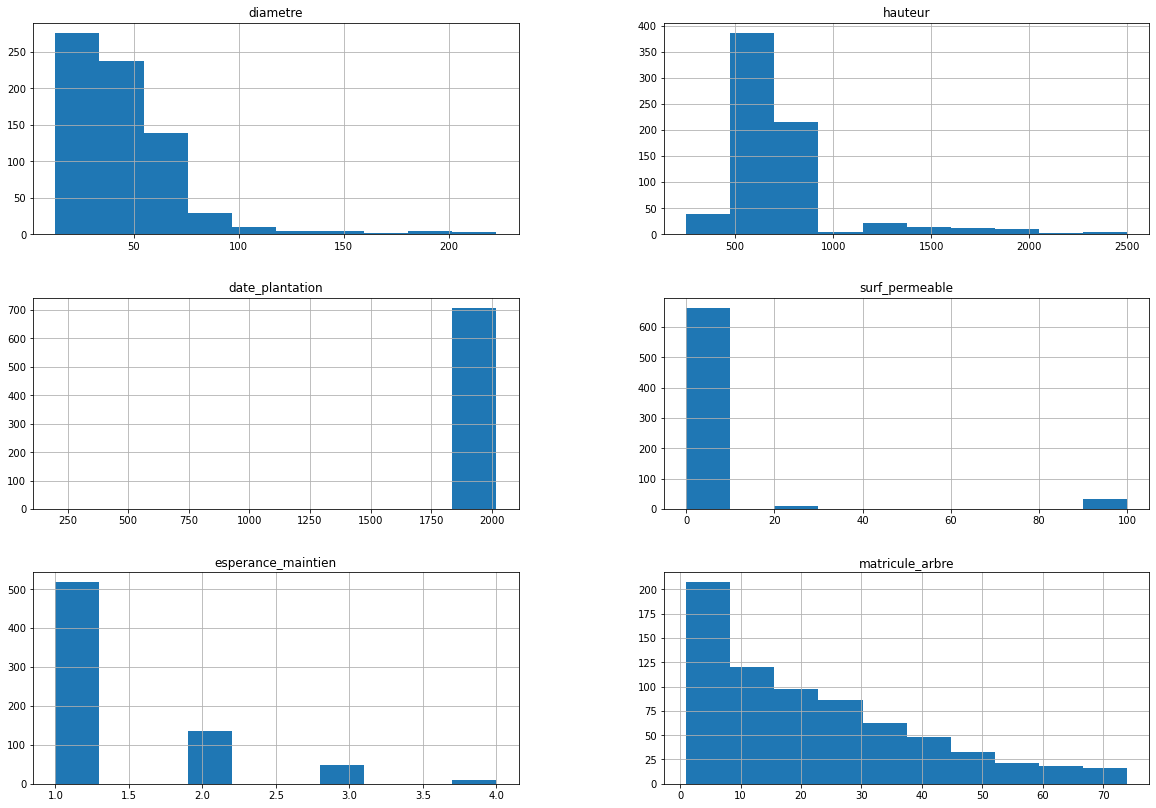

In [6]:
_ = df.hist(figsize=(20, 14))

In [7]:
cor_matrix = df.corr()
cor_matrix

,diametre,hauteur,date_plantation,surf_permeable,esperance_maintien,matricule_arbre
diametre,1.000000,0.759239,-0.155416,0.408231,0.329892,-0.109965
hauteur,0.759239,1.000000,-0.090306,0.604309,0.225723,-0.164903
date_plantation,-0.155416,-0.090306,1.000000,-0.071507,-0.033480,-0.007850
surf_permeable,0.408231,0.604309,-0.071507,1.000000,0.224826,-0.217633
esperance_maintien,0.329892,0.225723,-0.033480,0.224826,1.000000,-0.023423
matricule_arbre,-0.109965,-0.164903,-0.007850,-0.217633,-0.023423,1.000000


In [8]:
df.nunique()

quartier                      6
site                         30
cote_voirie                   2
contrainte                    2
genre_arbre                  26
espece_arbre                 37
situation                     4
type_sol                      9
plaie_houppier                5
bois_mort_houppier            3
classe_age                    4
ecorce_incluse_houppier       2
classe_hauteur                5
fissure_houppier              3
classe_circonference          7
port_arbre                    5
vigueur_pousse                4
champignon_collet             2
plaie_collet                  7
champignon_tronc              2
fissure_tronc                 3
rejet_tronc                   2
tuteurage_arbre               4
canisse_arbre                 2
plaie_tronc                   6
champignon_houppier           2
diametre                     42
hauteur                      17
date_plantation              13
surf_permeable                9
esperance_maintien            4
matricul

In [9]:
df['classification_diagnostic'].value_counts()

C2    408
C1    237
C3     43
C4     11
C5     10
Name: classification_diagnostic, dtype: int64

In [10]:
target_name = "classification_diagnostic"
target = df[target_name]
data = df.drop(columns=[target_name])

### One Hot Encoding for Categorical features and Standard Scaling for Numerical Features

In [11]:
from sklearn.compose import make_column_selector as selector
#Separating Numerical and Categorical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [12]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [13]:
from sklearn.compose import ColumnTransformer
## Creating separate Transformers
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

## Building Model Pipeline

### Logistic Regression Model with One Hot Encoding

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model_lr_ohe = make_pipeline(preprocessor, LogisticRegression(max_iter=500, random_state=0))

In [15]:
from sklearn import set_config
set_config(display='diagram')
model_lr_ohe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['quartier', 'site',
                                                   'cote_voirie', 'contrainte',
                                                   'genre_arbre',
                                                   'espece_arbre', 'situation',
                                                   'type_sol', 'plaie_houppier',
                                                   'bois_mort_houppier',
                                                   'classe_age',
                                                   'ecorce_incluse_houppier',
                                                   'classe_hauteur',
                                                   'fissure_houppier',
                                                   'classe_circ...
                                                   'champignon_collet',
                                                   'plaie_collet',
                                                   'champignon_tronc',
                                                   'fissure_tronc',
                                                   'rejet_tronc',
                                                   'tuteurage_arbre',
                                                   'canisse_arbre',
                                                   'plaie_tronc',
                                                   'champignon_houppier']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['diametre', 'hauteur',
                                                   'date_plantation',
                                                   'surf_permeable',
                                                   'esperance_maintien',
                                                   'matricule_arbre'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=0))])

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0, test_size=0.1)

In [17]:
%%time
logistic_regression_ohe_model = model_lr_ohe.fit(X_train, y_train)

Wall time: 181 ms


In [18]:
logistic_regression_ohe_model.score(X_test, y_test)

0.8873239436619719

In [19]:
logistic_regression_ohe_model.predict(X_test)[:5]

array(['C2', 'C2', 'C1', 'C1', 'C2'], dtype=object)

#### Model Evaluation with Cross-Validation

In [20]:
from sklearn.model_selection import cross_validate
start = time.process_time()
cv_results_lrm_ohe = cross_validate(logistic_regression_ohe_model, X_train, y_train, cv=5)
print("Test Scores for the Logistic Regression Model with 5-Fold Cross-Validation:")
print(cv_results_lrm_ohe["test_score"])
scores = cv_results_lrm_ohe["test_score"]
print("The Mean Cross-Validation Accuracy is: "f"{scores.mean():.3f} with Standard Deviation of +/- {scores.std():.3f}")
print("Total time taken: {:}".format(time.process_time() - start))

Test Scores for the Logistic Regression Model with 5-Fold Cross-Validation:
[0.8828125  0.8515625  0.8671875  0.84251969 0.85826772]
The Mean Cross-Validation Accuracy is: 0.860 with Standard Deviation of +/- 0.014
Total time taken: 0.625


### Logistic Regression with Ordinal Encoding

In [21]:
from sklearn.compose import make_column_selector as selector
#Separating Numerical and Categorical columns
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

categorical_columns = categorical_columns_selector(data)
data_categorical = data[categorical_columns]
data_categorical.head()

,quartier,site,cote_voirie,contrainte,genre_arbre,espece_arbre,situation,type_sol,plaie_houppier,bois_mort_houppier,...,vigueur_pousse,champignon_collet,plaie_collet,champignon_tronc,fissure_tronc,rejet_tronc,tuteurage_arbre,canisse_arbre,plaie_tronc,champignon_houppier
0,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Betula,Alba,Groupe,P,HPLC,HBMI,...,P,Non,RCPLNS,Non,TPF,Non,Non,Non,TPLNC,Non
1,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Betula,Alba,Groupe,P,HPLC,HBMI,...,P,Non,RCPPL,Non,TPF,Non,Non,Non,TPLC,Non
2,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Betula,Alba,Groupe,P,HPLC,HBMI,...,P,Non,RCPPL,Non,TPF,Non,Non,Non,TPLCF,Non
3,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,HPLS,HBMI,...,P,Non,RCPPL,Non,TPF,Non,Non,Non,TPLS,Non
4,Quartier 2 - Alsace - Pereire,Carrefour RN13,Impair,Non,Carpinus,Betulus - L. - Fastigiata,Bosquet,G,HPLS,HBMI,...,P,Non,RCPPL,Non,TPF,Non,Non,Non,TPLS,Non


In [22]:
print(f"The dataset is composed of {data_categorical.shape[1]} Categorical features")

The dataset is composed of 26 Categorical features


In [23]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

categorical_encoder = OrdinalEncoder()
data_encoded = categorical_encoder.fit_transform(data_categorical)
data_encoded.shape

(709, 26)

In [24]:
data_encoded[:5]

array([[1., 5., 0., 0., 4., 0., 2., 6., 0., 0., 0., 0., 1., 2., 1., 4.,
        2., 0., 4., 0., 2., 0., 0., 0., 2., 0.],
       [1., 5., 0., 0., 4., 0., 2., 6., 0., 0., 0., 0., 1., 2., 1., 4.,
        2., 0., 6., 0., 2., 0., 0., 0., 0., 0.],
       [1., 5., 0., 0., 4., 0., 2., 6., 0., 0., 0., 0., 1., 2., 1., 4.,
        2., 0., 6., 0., 2., 0., 0., 0., 1., 0.],
       [1., 5., 0., 0., 5., 8., 1., 2., 2., 0., 0., 0., 3., 2., 1., 1.,
        2., 0., 6., 0., 2., 0., 0., 0., 3., 0.],
       [1., 5., 0., 0., 5., 8., 1., 2., 2., 0., 0., 0., 3., 2., 5., 1.,
        2., 0., 6., 0., 2., 0., 0., 0., 3., 0.]])

In [25]:
print(
    f"The dataset encoded contains {data_encoded.shape[1]} features")

The dataset encoded contains 26 features


In [26]:
len(categorical_columns)

26

In [27]:
categorical_columns

['quartier',
 'site',
 'cote_voirie',
 'contrainte',
 'genre_arbre',
 'espece_arbre',
 'situation',
 'type_sol',
 'plaie_houppier',
 'bois_mort_houppier',
 'classe_age',
 'ecorce_incluse_houppier',
 'classe_hauteur',
 'fissure_houppier',
 'classe_circonference',
 'port_arbre',
 'vigueur_pousse',
 'champignon_collet',
 'plaie_collet',
 'champignon_tronc',
 'fissure_tronc',
 'rejet_tronc',
 'tuteurage_arbre',
 'canisse_arbre',
 'plaie_tronc',
 'champignon_houppier']

In [28]:
#Adding Numpy array into pandas data frame (Numerical columns)
data_cat_encoded_to_num = pd.DataFrame(data_encoded, columns=['quartier',
 'site',
 'cote_voirie',
 'contrainte',
 'genre_arbre',
 'espece_arbre',
 'situation',
 'type_sol',
 'plaie_houppier',
 'bois_mort_houppier',
 'classe_age',
 'ecorce_incluse_houppier',
 'classe_hauteur',
 'fissure_houppier',
 'classe_circonference',
 'port_arbre',
 'vigueur_pousse',
 'champignon_collet',
 'plaie_collet',
 'champignon_tronc',
 'fissure_tronc',
 'rejet_tronc',
 'tuteurage_arbre',
 'canisse_arbre',
 'plaie_tronc',
 'champignon_houppier'])

In [29]:
data_cat_encoded_to_num.head()

,quartier,site,cote_voirie,contrainte,genre_arbre,espece_arbre,situation,type_sol,plaie_houppier,bois_mort_houppier,...,vigueur_pousse,champignon_collet,plaie_collet,champignon_tronc,fissure_tronc,rejet_tronc,tuteurage_arbre,canisse_arbre,plaie_tronc,champignon_houppier
0,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,2.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0
1,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,2.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,2.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0
3,1.0,5.0,0.0,0.0,5.0,8.0,1.0,2.0,2.0,0.0,...,2.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0
4,1.0,5.0,0.0,0.0,5.0,8.0,1.0,2.0,2.0,0.0,...,2.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0


In [30]:
data_numerical = data[numerical_columns]
data_numerical_all_features= pd.concat([data_cat_encoded_to_num, data_numerical], axis=1)

In [31]:
data_numerical_all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   quartier                 709 non-null    float64
 1   site                     709 non-null    float64
 2   cote_voirie              709 non-null    float64
 3   contrainte               709 non-null    float64
 4   genre_arbre              709 non-null    float64
 5   espece_arbre             709 non-null    float64
 6   situation                709 non-null    float64
 7   type_sol                 709 non-null    float64
 8   plaie_houppier           709 non-null    float64
 9   bois_mort_houppier       709 non-null    float64
 10  classe_age               709 non-null    float64
 11  ecorce_incluse_houppier  709 non-null    float64
 12  classe_hauteur           709 non-null    float64
 13  fissure_houppier         709 non-null    float64
 14  classe_circonference     7

In [32]:
data_numerical_all_features.head()

,quartier,site,cote_voirie,contrainte,genre_arbre,espece_arbre,situation,type_sol,plaie_houppier,bois_mort_houppier,...,tuteurage_arbre,canisse_arbre,plaie_tronc,champignon_houppier,diametre,hauteur,date_plantation,surf_permeable,esperance_maintien,matricule_arbre
0,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,0.0,0.0,2.0,0.0,63.661977,1000,2000,5.0,1.0,7
1,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,60.478878,1000,2000,5.0,1.0,8
2,1.0,5.0,0.0,0.0,4.0,0.0,2.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,54.112681,1000,2000,5.0,1.0,9
3,1.0,5.0,0.0,0.0,5.0,8.0,1.0,2.0,2.0,0.0,...,0.0,0.0,3.0,0.0,63.661977,1600,1980,100.0,1.0,1
4,1.0,5.0,0.0,0.0,5.0,8.0,1.0,2.0,2.0,0.0,...,0.0,0.0,3.0,0.0,190.985932,1600,1980,100.0,1.0,2


In [33]:
data_hist= pd.concat([data_numerical_all_features, target], axis=1)

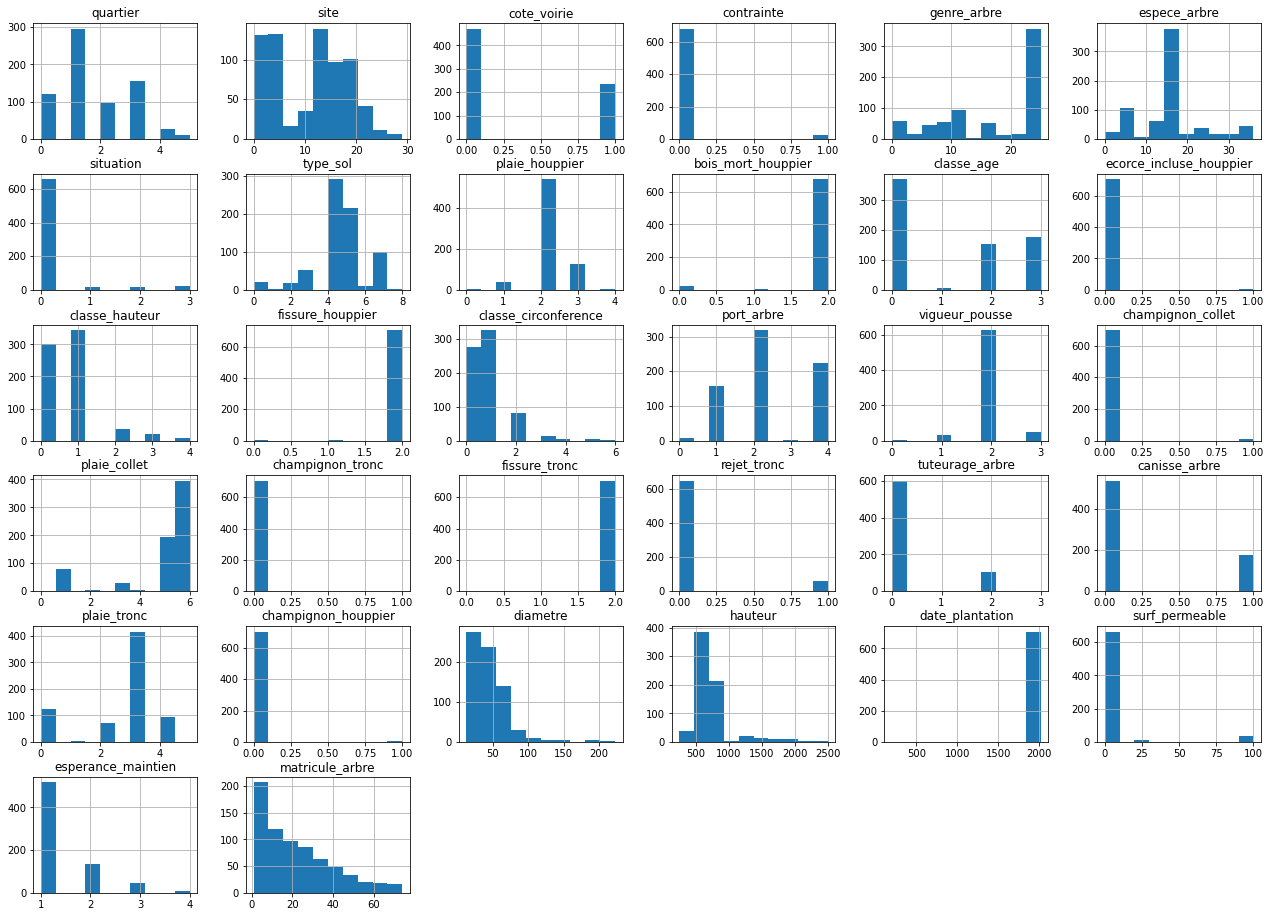

In [34]:
_ = data_hist.hist(figsize=(22, 16))

In [35]:
numerical_columns = numerical_columns_selector(data_numerical_all_features)
numerical_preprocessor = StandardScaler()
from sklearn.compose import ColumnTransformer
## Creating separate Transformers
preprocessor = ColumnTransformer([
    ('Standard_scaler', numerical_preprocessor, numerical_columns)])

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model_lr_oe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=0))

In [37]:
from sklearn import set_config
set_config(display='diagram')
model_lr_oe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Standard_scaler',
                                                  StandardScaler(),
                                                  ['quartier', 'site',
                                                   'cote_voirie', 'contrainte',
                                                   'genre_arbre',
                                                   'espece_arbre', 'situation',
                                                   'type_sol', 'plaie_houppier',
                                                   'bois_mort_houppier',
                                                   'classe_age',
                                                   'ecorce_incluse_houppier',
                                                   'classe_hauteur',
                                                   'fissure_houppier',
                                                   'classe_circonference',
                                                   'port_arbre',
                                                   'vigueur_pousse',
                                                   'champignon_collet',
                                                   'plaie_collet',
                                                   'champignon_tronc',
                                                   'fissure_tronc',
                                                   'rejet_tronc',
                                                   'tuteurage_arbre',
                                                   'canisse_arbre',
                                                   'plaie_tronc',
                                                   'champignon_houppier',
                                                   'diametre', 'hauteur',
                                                   'date_plantation',
                                                   'surf_permeable', ...])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=0))])

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_numerical_all_features, target, random_state=0, test_size=0.1)

In [39]:
%%time
logistic_regression_oe_model = model_lr_oe.fit(X_train, y_train)

Wall time: 98.8 ms


In [40]:
logistic_regression_oe_model.score(X_test, y_test)

0.7323943661971831

In [41]:
logistic_regression_oe_model.predict(X_test)[:5]

array(['C2', 'C2', 'C2', 'C1', 'C2'], dtype=object)

In [42]:
from sklearn.model_selection import cross_validate
start = time.process_time()
cv_results_lrm_oe = cross_validate(logistic_regression_oe_model, X_train, y_train, cv=5)
print("Test Scores for the Logistic Regression Model with 5-Fold Cross-Validation:")
print(cv_results_lrm_oe["test_score"])
scores = cv_results_lrm_oe["test_score"]
print("The Mean Cross-Validation Accuracy is: "f"{scores.mean():.3f} with Standard Deviation of +/- {scores.std():.3f}")
print("Total time taken: {:}".format(time.process_time() - start))

Test Scores for the Logistic Regression Model with 5-Fold Cross-Validation:
[0.8359375  0.8046875  0.765625   0.81102362 0.81889764]
The Mean Cross-Validation Accuracy is: 0.807 with Standard Deviation of +/- 0.023
Total time taken: 2.859375


### Decision Tree Model (Without Pruning)

In [43]:
from sklearn.tree import DecisionTreeClassifier

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)
model_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0, criterion='entropy'))
X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0, test_size=0.1)

In [44]:
from sklearn import set_config
set_config(display='diagram')
model_dt

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['quartier', 'site',
                                                   'cote_voirie', 'contrainte',
                                                   'genre_arbre',
                                                   'espece_arbre', 'situation',
                                                   'type_sol', 'plaie_houppier',
                                                   'bois_mort_houppier',
                                                   'classe_age',
                                                   '...luse_houppier',
                                                   'classe_hauteur',
                                                   'fissure_houppier',
                                                   'classe_circonference',
                                                   'port_arbre',
                                                   'vigueur_pousse',
                                                   'champignon_collet',
                                                   'plaie_collet',
                                                   'champignon_tronc',
                                                   'fissure_tronc',
                                                   'rejet_tronc',
                                                   'tuteurage_arbre',
                                                   'canisse_arbre',
                                                   'plaie_tronc',
                                                   'champignon_houppier'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=0))])

In [45]:
%%time
decision_tree_model_no_pruning = model_dt.fit(X_train, y_train)

Wall time: 16.7 ms


In [46]:
decision_tree_model_no_pruning.score(X_test, y_test)

0.8309859154929577

In [47]:
decision_tree_model_no_pruning.predict(X_test)[:5]

array(['C2', 'C2', 'C1', 'C1', 'C2'], dtype=object)

In [48]:
start = time.process_time()
cv_results_dtmnp = cross_validate(decision_tree_model_no_pruning, X_train, y_train, cv=5)
print("Test Scores for the Decision Tree Model with 5-Fold Cross-Validation:")
print(cv_results_dtmnp["test_score"])
scores = cv_results_dtmnp["test_score"]
print("The Mean Cross-Validation Accuracy is: "f"{scores.mean():.3f} with Standard Deviation of +/- {scores.std():.3f}")
print("Total time taken: {:}".format(time.process_time() - start))

Test Scores for the Decision Tree Model with 5-Fold Cross-Validation:
[0.8359375  0.7890625  0.8671875  0.81102362 0.8503937 ]
The Mean Cross-Validation Accuracy is: 0.831 with Standard Deviation of +/- 0.028
Total time taken: 0.328125


In [64]:
decision_tree_model_no_pruning.tree_

AttributeError: 'Pipeline' object has no attribute 'tree_'

### Pruning decision trees with cost complexity pruning and analysing results
Total impurity of leaves vs effective alphas of pruned tree
Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    data_numerical_all_features, target, random_state=0, test_size=0.1)
classifier = DecisionTreeClassifier(random_state=0, criterion= "entropy")
classifier.fit(X_train, y_train)
path = classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

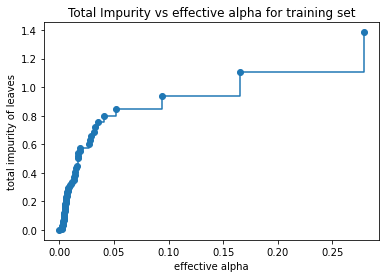

In [50]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:], impurities[:], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [51]:
classifiers = []
for ccp_alpha in ccp_alphas:
    classifier = DecisionTreeClassifier(random_state=0, criterion="entropy", ccp_alpha=ccp_alpha)
    classifier.fit(X_train, y_train)
    classifiers.append(classifier)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        classifiers[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.278873329597614


For the remainder of this example, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

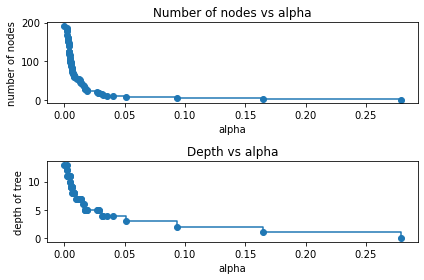

In [52]:
#classifiers = classifiers[:-1]
#ccp_alphas = ccp_alphas[:-1]

node_counts = [classifier.tree_.node_count for classifier in classifiers]
depth = [classifier.tree_.max_depth for classifier in classifiers]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
#ax[1].set_yscale("log")
#ax[1].set_xscale("log")
fig.tight_layout()

Accuracy vs alpha for training and testing sets
When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, setting ccp_alpha=0.015 maximizes the testing accuracy.

In [66]:
classifier.tree_.max_depth

0

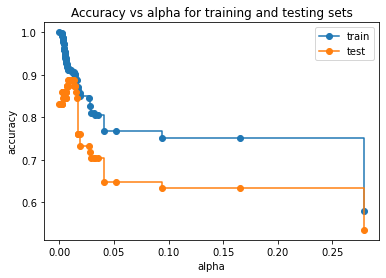

In [53]:
train_scores = [classifier.score(X_train, y_train) for classifier in classifiers]
test_scores = [classifier.score(X_test, y_test) for classifier in classifiers]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

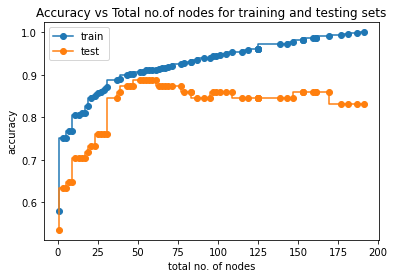

In [67]:
train_scores = [classifier.score(X_train, y_train) for classifier in classifiers]
test_scores = [classifier.score(X_test, y_test) for classifier in classifiers]
node_counts = [classifier.tree_.node_count for classifier in classifiers]
fig, ax = plt.subplots()
ax.set_xlabel("total no. of nodes")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs Total no.of nodes for training and testing sets")
ax.plot(node_counts, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(node_counts, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [68]:
node_counts = [classifier.tree_.node_count for classifier in classifiers]
node_counts

[191,
 187,
 181,
 177,
 169,
 161,
 161,
 159,
 153,
 153,
 153,
 147,
 143,
 139,
 125,
 125,
 125,
 125,
 125,
 119,
 115,
 109,
 105,
 101,
 99,
 97,
 95,
 91,
 87,
 83,
 83,
 79,
 77,
 71,
 69,
 67,
 65,
 63,
 61,
 59,
 57,
 55,
 53,
 51,
 47,
 45,
 43,
 39,
 37,
 31,
 29,
 27,
 25,
 23,
 21,
 19,
 17,
 15,
 13,
 11,
 9,
 7,
 5,
 3,
 1]

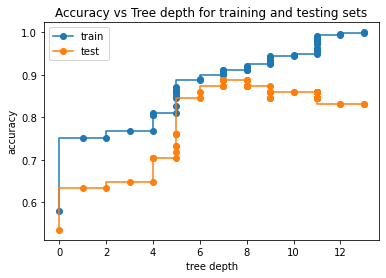

In [55]:
train_scores = [classifier.score(X_train, y_train) for classifier in classifiers]
test_scores = [classifier.score(X_test, y_test) for classifier in classifiers]
depth = [classifier.tree_.max_depth for classifier in classifiers]
fig, ax = plt.subplots()
ax.set_xlabel("tree depth")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs Tree depth for training and testing sets")
ax.plot(depth, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(depth, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [70]:
depth = [classifier.tree_.max_depth for classifier in classifiers]
depth

[13,
 13,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 3,
 2,
 1,
 0]

In [56]:
test_scores = np.asarray(test_scores)
test_scores.shape

(65,)

In [57]:
print(np.concatenate((ccp_alphas.reshape(len(ccp_alphas),1), test_scores.reshape(len(test_scores),1)),1))

[[0.         0.83098592]
 [0.002159   0.83098592]
 [0.00253644 0.83098592]
 [0.00254319 0.83098592]
 [0.00269508 0.85915493]
 [0.00282887 0.85915493]
 [0.00282887 0.85915493]
 [0.00297827 0.85915493]
 [0.0031348  0.85915493]
 [0.0031348  0.85915493]
 [0.0031348  0.85915493]
 [0.00360324 0.84507042]
 [0.00380467 0.84507042]
 [0.00398602 0.84507042]
 [0.00431801 0.84507042]
 [0.00431801 0.84507042]
 [0.00431801 0.84507042]
 [0.00431801 0.84507042]
 [0.00431801 0.84507042]
 [0.0043204  0.84507042]
 [0.00470219 0.84507042]
 [0.00470676 0.85915493]
 [0.00478046 0.85915493]
 [0.0049948  0.85915493]
 [0.00508638 0.85915493]
 [0.00534469 0.85915493]
 [0.00552417 0.84507042]
 [0.00571682 0.84507042]
 [0.00598391 0.84507042]
 [0.00611306 0.85915493]
 [0.00611306 0.85915493]
 [0.0064697  0.85915493]
 [0.00665016 0.87323944]
 [0.00678184 0.87323944]
 [0.00703797 0.87323944]
 [0.00760933 0.87323944]
 [0.00788634 0.87323944]
 [0.00797205 0.87323944]
 [0.00815958 0.88732394]
 [0.00850942 0.88732394]


### Tuning for Best Pruning Parameters with randomized-search

In [58]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

from scipy.stats import uniform
class uniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = uniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [59]:
from sklearn.tree import DecisionTreeClassifier

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

In [60]:
from sklearn.pipeline import Pipeline

model_dtpp = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(criterion= "entropy", random_state=0)),
])


In [61]:
from sklearn import set_config
set_config(display='diagram')
model_dtpp

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['quartier', 'site',
                                                   'cote_voirie', 'contrainte',
                                                   'genre_arbre',
                                                   'espece_arbre', 'situation',
                                                   'type_sol', 'plaie_houppier',
                                                   'bois_mort_houppier',
                                                   'classe_age',
                                                   'ecorce_incluse_houppier',
                                                   'classe_hauteur',
                                                   'fissure_houppier',
                                                   'classe_circonference',
                                                   'port_arbre',
                                                   'vigueur_pousse',
                                                   'champignon_collet',
                                                   'plaie_collet',
                                                   'champignon_tronc',
                                                   'fissure_tronc',
                                                   'rejet_tronc',
                                                   'tuteurage_arbre',
                                                   'canisse_arbre',
                                                   'plaie_tronc',
                                                   'champignon_houppier'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=0))])

In [62]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__ccp_alpha': uniform(0.005, 0.02),
    'classifier__max_depth': loguniform_int(5, 11),
    'classifier__max_leaf_nodes': loguniform_int(34, 76),
}

model_random_search_dtpp = RandomizedSearchCV(
    model_dtpp, param_distributions=param_distributions, n_iter=2000,
    cv=5, verbose=1, random_state =0
)
model_random_search_dtpp.fit(X_train, y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


KeyboardInterrupt: 

In [63]:
accuracy = model_random_search_dtpp.score(X_test, y_test)

print(f"The test accuracy score of the best model is "
      f"{accuracy:.2f}")

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search_dtpp.best_params_)


We can inspect the results using the attributes `cv_results` as we did
previously.

In [ ]:
# get the parameter names
column_results = [
    f"param_{name}" for name in param_distributions.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search_dtpp.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results.head(200)

In [ ]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

In [ ]:
import seaborn as sns

df_tuning = pd.DataFrame(
    {
        "max_leaf_nodes": cv_results["max_leaf_nodes"],
        "ccp_alpha": cv_results["ccp_alpha"],
        "score_bin": pd.cut(
            cv_results["mean_test_score"], bins=np.linspace(0.832296, 0.847970, 7)
        ),
    }
)
sns.set_palette("YlGnBu_r")
ax = sns.scatterplot(
    data=df_tuning,
    x="ccp_alpha",
    y="max_leaf_nodes",
    hue="score_bin",
    s=28,
    color="k",
    edgecolor=None,
)
#ax.set_xscale("log")
#ax.set_yscale("log")

_ = ax.legend(title="mean_test_score", loc="center left", bbox_to_anchor=(1, 0.5))

In [ ]:
import seaborn as sns

df_tuning = pd.DataFrame(
    {
        "max_depth": cv_results["max_depth"],
        "ccp_alpha": cv_results["ccp_alpha"],
        "score_bin": pd.cut(
            cv_results["mean_test_score"], bins=np.linspace(0.832296, 0.847970, 7)
        ),
    }
)
sns.set_palette("YlGnBu_r")
ax = sns.scatterplot(
    data=df_tuning,
    x="ccp_alpha",
    y="max_depth",
    hue="score_bin",
    s=15,
    color="k",
    edgecolor=None,
)
#ax.set_xscale("log")
#ax.set_yscale("log")

_ = ax.legend(title="mean_test_score", loc="center left", bbox_to_anchor=(1, 0.5))

In [ ]:
#pd.to_numeric(cv_results["max_depth", "ccp_alpha", "max_leaf_nodes"]) 
cv_results["max_depth"] = pd.to_numeric(cv_results["max_depth"])
cv_results["ccp_alpha"] = pd.to_numeric(cv_results["ccp_alpha"])
cv_results["max_leaf_nodes"] = pd.to_numeric(cv_results["max_leaf_nodes"])
cv_results.info()

In [ ]:
cv_results_plot= cv_results.drop(["std_test_score"], axis=1)
import plotly.express as px

fig = px.parallel_coordinates(
    cv_results_plot,
    color="mean_test_score",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()

### Final Decision Tree Model with Pruning

In [ ]:
model_dtp = make_pipeline(preprocessor, DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=8, max_leaf_nodes= 90, ccp_alpha=0.00667))

In [ ]:
from sklearn import set_config
set_config(display='diagram')
model_dtp

In [ ]:
%%time
decision_tree_model_pruning = model_dtp.fit(X_train, y_train)

In [ ]:
decision_tree_model_pruning.score(X_test, y_test)

In [ ]:
start = time.process_time()
cv_results_dtmp = cross_validate(decision_tree_model_pruning, X_train, y_train, cv=5)
print("Test Scores for the Final Decision Tree Model (Pruning) with 5-Fold Cross-Validation:")
print(cv_results_dtmp["test_score"])
scores = cv_results_dtmp["test_score"]
print("The Mean Cross-Validation Accuracy is: "f"{scores.mean():.3f} with Standard Deviation of +/- {scores.std():.3f}")
print("Total time taken: {:}".format(time.process_time() - start))